## ECG Classification Using Convolutional Neural Networks

Author: Calvin Chan 

### Introduction
In our last notebook, we will use the concept of convolution to model our ECG timeseries data. Traditionally, image analysis uses a 2D convolution to extract features from images, however since we are working with signals this would not work. Instead of 2D convolutions, we can convolve over our signals using a 1D framework. 

### Table of Contents

Here, we import all the necessary packages used in this notebook.

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn
import load_functions as f
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from tqdm.notebook import trange, tnrange, tqdm_notebook
from torch.utils.data import TensorDataset, DataLoader

import sys
sys.path.append('..')
from Notebooks import ecg_cleaning as c

### Data Import

Below we load our full data set.

In [2]:
# File Path
path = '../data/physionet.org/files/ptb-xl/1.0.3/'
metadata = pd.read_csv('../data/cleaned_metadata.csv')

# Import data
full_data = f.load_signal(path, metadata)

In [3]:
# Let's look at the data shape 
full_data[0].shape, full_data[1].shape

((15677, 1000, 12), (15677,))

We also want to look at Lead II only. 

In [4]:
# Slicing only for Lead II 
X = full_data[0][:,:,1]
y = full_data[1]

X.shape, y.shape

((15677, 1000), (15677,))

### Data Preprocessing 

In [5]:
# Transform target column into binary classes
y = y.apply(lambda x: f.binary(x))

In [6]:
# Sanity check
y.value_counts()

diagnostic_superclass
ABNO    8645
NORM    7032
Name: count, dtype: int64

In [7]:
# Instantiate LabelEncoder 
label = LabelEncoder()

# Fit binary classes
label.fit(y)

# Transform classes
y = label.transform(y)

In [8]:
# Checking how our label is encoded
label.transform(['ABNO', 'NORM'])

array([0, 1])

As we can see, signals that are labeled `ABNO` are mapped to `0` and `NORM` are mapped `1`. 

#### Signal denoising using ecg_cleaning.py

In this following section, we denoise our ECG signals using Fourier Tranforms. We have to specify the frequencies in which we want to take out for baseline wandering and powerline interference. 

In [9]:
X.shape

(15677, 1000)

In [10]:
# Low sampling frequency
sig_len = 1000
sampling_frequency = 100
time = np.arange(0, sig_len) / sampling_frequency

# Baseline and PLI removal
signal_bl = np.apply_along_axis(c.baseline_removal, axis=1, arr=X, freq_start=0.1, freq_stop=1.5)
signal_pli = np.apply_along_axis(c.high_freq_removal, axis=1, arr=signal_bl, freq_start=40)

In [11]:
signal_pli.shape

(15677, 1000)

#### Train Test Split

After preprocessing our signals, we can split our data set to training and testing. We will use `20%` of our data as testing and the rest as training. Since we have a data imbalance, we will include `stratify` as well.  

In [12]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(signal_pli, y, test_size=0.2, stratify=y)

# Checking the shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12541, 1000), (3136, 1000), (12541,), (3136,))

#### Scaling 

Next, we want to scale our data. Since we are using using a neural network, as we calculate the gradient during backpropagation, distances can affect how well this is performed. We will use `StandardScaler` for our case.

In [13]:
# Instantiate standard scaler
ss = StandardScaler()

# Fit and transform training set
X_train = ss.fit_transform(X_train)

# Transform testing set
X_test = ss.transform(X_test)

#### Transforming arrays into Torch Tensors

In [14]:
# Transforming independent variables
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Transforming dependent variables
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Sanity check
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([12541, 1000]) torch.Size([3136, 1000]) torch.Size([12541]) torch.Size([3136])


#### Data Loaders

In [62]:
####### Setting batch size #######
batch_size = 128

# Shuffle training set
training_loader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=batch_size, shuffle=True)

# Don't shuffle validation set
testing_loader = DataLoader(TensorDataset(X_test.unsqueeze(1), y_test.unsqueeze(1)), batch_size=batch_size, shuffle=False)

### Model Setup and Implementation

In [45]:
class SimpleCNN(nn.Module):
    """Starting off with a simple cnn."""
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Defining convolution layers
        self.conv_layer = nn.Sequential(
            
            # Convolution block 1
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=None),
            
            # Convolution block 2
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=None),
        )
        
        # Drop out layer 
        self.dropout = nn.Dropout1d(0.15)
        
        # Fully-connected layer
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=32*250, out_features=400),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=400, out_features=16),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=16, out_features=1),
        )
        
        # Output layer 
        self.sigmoid = nn.Sigmoid()

        # Loss function
        self.binary_entropy_loss = nn.BCELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        
    def forward(self, x): 
        """Perform forward pass."""

        # Pass through convolution layers
        x = self.conv_layer(x)
        
        # Flatten the output after convolution
        x = x.view(x.size(0), -1)
        
        # Apply drop out
        x = self.dropout(x)

        # Pass through fully-connected layer
        x = self.fc_layer(x)

        # If training, repeat, else, compute output layer
        if not self.training:
            x = self.sigmoid(x)

        return x

    def predict(self, x):
        """Make prediction."""

        predictions = self.forward(x)

        # Hard class prediction: output from sigmoid with the higher percentage
        hard_class_prediction = torch.argmax(predictions, dim=1)

        return hard_class_prediction


#### Example training of 1 signal

In [46]:
# Sample training 

sample = X_train[0]
sample_label = y_train[0]

print(sample.shape, sample_label.shape)

torch.Size([1000]) torch.Size([])


In [47]:
sample.unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 1000])

In [48]:
# Initializing the model

cnn_model = SimpleCNN()
cnn_model

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU(inplace=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout1d(p=0.15, inplace=False)
  (fc_layer): Sequential(
    (0): Linear(in_features=8000, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=16, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
  (binary_entropy_loss): BCELoss()
)

In [21]:
# Clear any gradients from previous run (in this case this is our first and only run)
cnn_model.optimizer.zero_grad()

In [22]:
# Pass through 1 training signal to model after reshaping size
outputs = cnn_model(sample.unsqueeze(0).unsqueeze(0))

In [23]:
# Compute the binary entropy loss after one training and label 
loss = cnn_model.binary_entropy_loss(outputs.sigmoid(), sample_label.unsqueeze(0).unsqueeze(0))

In [24]:
# Loss
loss.item()

0.7757506370544434

In [25]:
# Backpropagation 
loss.backward()

In [26]:
# Update weights
cnn_model.optimizer.step()

### Simple Training Model

In [63]:
lr = 0.001

CNN_model_2 = SimpleCNN()

binary_entropy_loss = nn.BCELoss()

optimizer = torch.optim.Adam(CNN_model_2.parameters(), lr=lr)

In [64]:
epoch_number = 0

total_train_loss = []
total_test_loss = []

for epoch in trange(25, desc="Total epochs :"):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    # Training 
    running_loss = 0
    last_loss = 0
    
    CNN_model_2.train(True)
    
    for i, data in enumerate(training_loader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = CNN_model_2(inputs)
        
        loss = binary_entropy_loss(outputs.sigmoid(), labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
    total_train_loss.append(running_loss)
    
    # Testing
    running_tloss = 0.0
    
    CNN_model_2.eval()
    
    with torch.no_grad():
        for i, tdata in enumerate(testing_loader):
            tinputs, tlabels = tdata
            toutputs = CNN_model_2(tinputs)
            tloss = binary_entropy_loss(toutputs.sigmoid(), tlabels)
            running_tloss += tloss
            
    avg_tloss = running_tloss / (i + 1)
    total_test_loss.append(avg_tloss)
    
    epoch_number += 1
    
    print('LOSS train {} test {}'.format(running_loss, avg_tloss))
    
print(f"Optimization ended successfully")

Total epochs ::   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH 1
LOSS train 61.419566571712494 valid 0.7053996324539185
EPOCH 2
LOSS train 57.10231393575668 valid 0.7118154168128967
EPOCH 3
LOSS train 53.25187286734581 valid 0.6865294575691223
EPOCH 4
LOSS train 48.22863185405731 valid 0.6868211627006531
EPOCH 5
LOSS train 43.50026321411133 valid 0.664866030216217
EPOCH 6
LOSS train 40.67124545574188 valid 0.6489605903625488
EPOCH 7
LOSS train 35.24500493705273 valid 0.6426914930343628
EPOCH 8
LOSS train 29.749459877610207 valid 0.6524726152420044
EPOCH 9
LOSS train 23.4884831905365 valid 0.6363000273704529
EPOCH 10
LOSS train 19.365352980792522 valid 0.633962869644165
EPOCH 11
LOSS train 17.396748900413513 valid 0.6377379894256592
EPOCH 12
LOSS train 13.715776715427637 valid 0.6354734897613525
EPOCH 13
LOSS train 14.63328082114458 valid 0.6501156687736511
EPOCH 14
LOSS train 14.072751995176077 valid 0.6410595178604126
EPOCH 15
LOSS train 12.660690296441317 valid 0.6398739814758301
EPOCH 16
LOSS train 13.73697393015027 valid 0.64125651121139

### Accuracy Scores

In [77]:
X_train[0].unsqueeze(0).shape

torch.Size([1, 1000])

In [76]:
CNN_model_2.predict(X_train[0].unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x250 and 8000x400)

In [68]:
# Make predictions
binary_classification = CNN_model_2.predict(X_train.unsqueeze(1))

# Calculate the score on the test set
accuracy = accuracy_score(y_train, binary_classification)
print(f"Accuracy score on train set: {round(accuracy * 100, 2)}%")

Accuracy score on train set: 55.15%


In [69]:
# Make predictions
binary_classification = CNN_model_2.predict(X_test.unsqueeze(1))

# Calculate the score on the test set
accuracy = accuracy_score(y_test, binary_classification)
print(f"Accuracy score on testing set: {round(accuracy * 100, 2)}%")

Accuracy score on train set: 55.13%


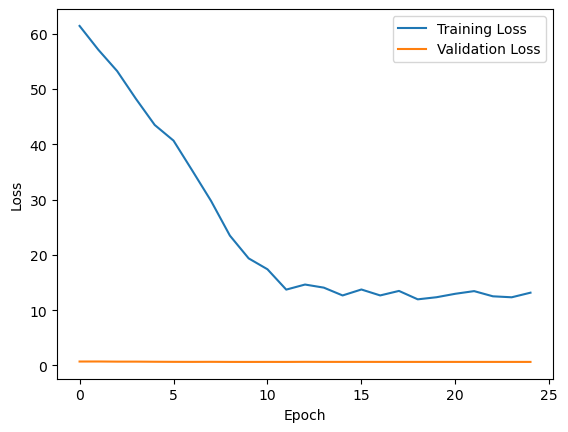

In [79]:

plt.figure()
plt.plot(total_train_loss, label="Training Loss")
plt.plot(total_test_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Training

In [118]:
X_train.shape

torch.Size([12541, 1000])

In [119]:
 y_train.unsqueeze(1).shape

torch.Size([12541, 1])

In [120]:
# For both sets
train_data = TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1))
test_data = TensorDataset(X_test.unsqueeze(1), y_test)

In [121]:
# This iterator returns four training examples at a time so we will update the model after every 4 images
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)

# This iterator returns 1024 test examples at a time (for fast testing)
test_dataloader = DataLoader(test_data, batch_size=512, shuffle=False)

In [122]:
# Re-initiliaze the model
CNN_model = SimpleCNN()

In [123]:
def get_accuracy(model, dataloader):
    '''
    Helper function to get classification accuracy for a model over the items in dataloader.
    taken from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    '''
    correct = 0
    total = 0


    # Go through all of the data
    for i, data in enumerate(test_dataloader, 0):
    #for batch in dataloader:
        images, labels = data

        # Get the prediction of the net on the images
        predicted = model.predict(images)


        total += labels.size(0)

        # Count those we got correct
        correct += (predicted == labels).sum().item()

    return(100 * correct / total)


print(f"Pre training accuracy: {get_accuracy(CNN_model, test_dataloader)}%")

Pre training accuracy: 55.13392857142857%


In [98]:
# MAIN EPOCH LOOP: the epochs are the number of times we loop through the entire training set.
for epoch in tnrange(10, desc="Total epochs: "):
    
    loss_sum = 0
    acc_sum = 0
    
    # BATCH LOOP: loop over the data batches using the data loader 
    # if you don't have tqdm installed, just use this simpler for-loop instead
    # for batch in train_dataloader: 
    for i, data in enumerate(train_dataloader, 0):

        # get the inputs
        inputs, labels = data
        
        # FORWARD PASS and loss calculation
        outputs = CNN_model(inputs)
        loss = CNN_model.binary_entropy_loss(outputs.sigmoid(), labels)
        
        # BACKWARD PASS but zero the gradients first to delete the old ones
        # as pytorch accumulates gradients by default
        CNN_model.optimizer.zero_grad()
        loss.backward()

        # UPDATE: the model weights are updated
        CNN_model.optimizer.step()
        
        # MONITORING: save loss and accuracy on the batch to track the training
        loss_sum += loss.item()

        # Get the prediction of the net on the images
        predicted = CNN_model.predict(inputs)
        acc_sum += (labels == predicted).sum().item() / labels.shape[0]
        
    
    # Print summary of training metrics
    loss_avg = loss_sum / len(train_dataloader)
    acc_avg = acc_sum / len(train_dataloader)
    test_acc = get_accuracy(CNN_model, test_dataloader)
    
    print(f"Avg loss: {np.round(loss_avg, 4)} | "\
          f"Avg training accuracy: {np.round(acc_avg*100, 2)} | "\
          f"Avg validation accuracy: {np.round(test_acc, 2)}")

print('Finished Training') 

Total epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Avg loss: 0.6888 | Avg training accuracy: 441.07 | Avg validation accuracy: 55.13
Avg loss: 0.6472 | Avg training accuracy: 441.07 | Avg validation accuracy: 55.13
Avg loss: 0.5765 | Avg training accuracy: 441.07 | Avg validation accuracy: 55.13
Avg loss: 0.532 | Avg training accuracy: 441.07 | Avg validation accuracy: 55.13
Avg loss: 0.4616 | Avg training accuracy: 441.07 | Avg validation accuracy: 55.13
Avg loss: 0.3551 | Avg training accuracy: 441.07 | Avg validation accuracy: 55.13
Avg loss: 0.2617 | Avg training accuracy: 441.07 | Avg validation accuracy: 55.13
Avg loss: 0.1991 | Avg training accuracy: 441.07 | Avg validation accuracy: 55.13


KeyboardInterrupt: 

In [125]:
# Now run for 100 epochs
for epoch in tnrange(10, desc="Total epochs: "):
  
    # Clear gradients (pytorch accumulates gradients by default)
    CNN_model.optimizer.zero_grad() 

    # Calculate outputs
    output_values = CNN_model(X_train.unsqueeze(1))

    # Calculate loss
    loss = CNN_model.binary_entropy_loss(output_values.sigmoid(), y_train.unsqueeze(1)) 

    # Backpropagation & weight adjustment
    loss.backward()
    CNN_model.optimizer.step()
    
    print(f"Epoch: {epoch}")

print(f"Optimization ended successfully")

Total epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Optimization ended successfully


In [126]:
from sklearn.metrics import accuracy_score

# Make predictions
binary_classification = CNN_model.predict(X_test.unsqueeze(1))

# Calculate the score on the test set
accuracy = accuracy_score(y_test, binary_classification)
print(f"Accuracy score on test set: {round(accuracy * 100, 2)}%")

Accuracy score on test set: 55.13%
